# The relationship between spatial coupling and incidence correlation in a 2-patch model
Ref: Keeling & Rohani, _Estimating spatial coupling in epidemiological systems: a mechanistic approach_, Ecol. Letters (2002) 5:20-29


In [1]:
import numpy as np
import pandas as pd
from laser_core.propertyset import PropertySet
import matplotlib.pyplot as plt
from scipy.optimize import fsolve

from laser_generic import Model
from laser_generic import Infection
from laser_generic import Susceptibility
from laser_generic import Transmission
from laser_generic import Births_ConstantPop
from laser_generic.importation import Infect_Random_Agents

from laser_generic.utils import set_initial_susceptibility_in_patch
from laser_generic.utils import seed_infections_in_patch

%load_ext line_profiler

f"{np.__version__=}"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


"np.__version__='1.26.4'"

In [19]:
%%capture
import os

#Set parameters to match those of Keeling & Rohani, 2002.  They have a constant importation rate of 5.5e-5*sqrt(N) per day,
#which for this sim would be something like 40 per year.  I'm importing 6 per year, but I don't think that should be the big deal.
#more important is setting the birth, R0, and infectious period to their numbers and then seeing the 
#connectivity-correlation relationship.
nticks = 36500
scenario = pd.DataFrame(data=[["patch1", 1e6],
                        ["patch2", 1e6]], 
                        columns=["name", "population"])
parameters = PropertySet({"seed": 4, 
                        "nticks": nticks,
                        "verbose": True, 
                        "beta": 17/13,
                        "inf_mean": 13,
                        "cbr": 20.277294, 
                        "importation_period": 180, 
                        "importation_count": 3, 
                        "importation_start": 500,
                        })

mu = ((1+parameters.cbr/1000)**(1/365)-1) 
R0 = parameters.beta/(mu + 1/parameters.inf_mean)
nsims = 100
i = 0
outputs = np.zeros((nsims, parameters.nticks, scenario.shape[0]))
# Create a folder to store the outputs
output_folder = "twopatchSIRoutputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
for connection in np.logspace(-4, -1, nsims):
    model = Model(scenario, parameters)
    model.components = [Births_ConstantPop,
        Susceptibility,
        Transmission,
        Infection,
        Infect_Random_Agents,
    ]   

    #Start them slightly asynchronously - different initial susceptibilities, infection only in 1 patch
    #Want to see how connectivity drives correlation over time.
    model.patches.network = np.array([[0, connection], [connection, 0]])
    set_initial_susceptibility_in_patch(model, 1, 1/R0+.02*np.random.normal())
    set_initial_susceptibility_in_patch(model, 0, 1/R0+.02*np.random.normal())
    seed_infections_in_patch(model, ipatch=0, ninfections=3)


    model.run()
    outputs[i, :, :] = model.patches.cases
    np.save(f"{output_folder}/twopatchSIRoutputs_{i}.npy", outputs[i, :, :])
    i+=1



ModuleNotFoundError: No module named 'openpyxl'

In [53]:
correlations = []
last_50_years = 50 * 365  # 50 years in days

for sim in range(outputs.shape[0]):
    patch1_data = outputs[sim, -last_50_years:, 0]
    patch2_data = outputs[sim, -last_50_years:, 1]
    correlation = np.corrcoef(patch1_data, patch2_data)[0, 1]
    correlations.append(correlation)

correlations = np.array(correlations)
print(correlations)

[ 0.44094658  0.24447214  0.02032732 -0.30724173  0.0735094   0.3508964
 -0.06549149  0.11147734  0.00246283  0.25219579 -0.24714577  0.08823306
  0.18398089 -0.24002168  0.21919256  0.15961621 -0.00375986  0.0832876
 -0.26609436  0.16067629  0.30372147  0.23600682  0.156628    0.2036784
  0.25260132  0.34182496  0.25914195  0.21351795  0.36730541  0.31323968
  0.34134352  0.25366452  0.30482308  0.31722081  0.33438612  0.27974796
  0.21260792  0.41038532 -0.04006728  0.22509534  0.04618833  0.12102017
  0.34179204  0.18591263  0.1748175   0.25892229  0.15084575  0.20616125
  0.19531214  0.3371837   0.0646105   0.38524797  0.27534632  0.37354017
  0.20971851  0.33799627  0.45098631  0.40544445  0.27239849  0.49067987
  0.26254371  0.4793981   0.46313531  0.46988172  0.47623691  0.46033411
  0.39466245  0.50581673  0.43902131  0.48345806  0.51619326  0.51915888
  0.61603541  0.54495446  0.5806436   0.60671775  0.54130043  0.61884162
  0.69273554  0.74709039  0.7490212   0.66960565  0.70

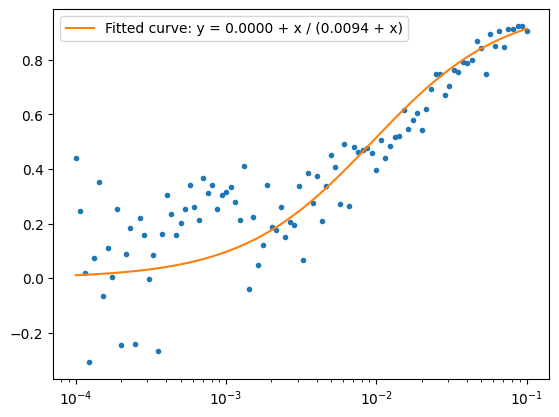

Bad pipe message: %s [b'\xba\xca\x81FN\x15\xa2T\xa8\x0b\x7f\xdat\xf6dCo\xa7\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00']
Bad pipe message: %s [b',d8\xbb\xcf\x0c\xbeK\x84q\xa1\x9f\xe9is\x06\xb7\x8a\x00\x01|\x00\x00\x00\x01\x00\x02\x00\x03\x00\x04\x00\x05\x00\x06\x00\x07\x00\x08\x00\t\x00\n\x00\x0b\x00\x0c\x00\r\x00\x0e\x00\x0f\x00\x10\x00\x11\x00\x12\x00\x13\x00\x14\x00\x15\x00\x16\x00\x17\x00\x18\x00\x19\x00\x1a\x00\x1b\x00/\x000\x001\x002\x003\x004\x005\x006\x007\x008\x009\x00:\x00;\x00<\x00=\x00>\x00?\x00@\x00A\x00B\x00C\x00D\x00E\x00F\x00g\x00h\x00i\x00j\x00k\x00l\x00m\x00\x84\x00\x85\x00\x86\x00\x87\x00\x88\x00\x89\x00\x96\x00\x97\x00\x98\x00\x99\x00\x9a\x00\x9b\x00\x9c\x00\x9d\x00\x9e\x00\x9f\x00\xa0\x00\xa1\x00\xa2\x00\xa3\x00\xa4\x00\xa5\x00\xa6\x00\xa7\x00\xba\x00\xbb\x00\xbc\x00\xbd\x00\xbe\x

In [54]:
from scipy.optimize import curve_fit
x = np.logspace(-4, -1, nsims)
# Define the function to fit
def func(x, psi, beta):
    return beta + x / (psi +x)
# Fit the curve
popt, pcov = curve_fit(func, x, correlations, p0=[0.01, 0], bounds=([1e-6, -0.00002], [1, 0.00002]))
psi_opt = popt[0]
beta_opt = popt[1]
plt.plot(x, correlations, '.')
plt.xscale('log')
# Plot the fitted curve
plt.plot(x, func(x, psi_opt, beta_opt), label=f'Fitted curve: y = {beta_opt:.4f} + x / ({psi_opt:.4f} + x)')
plt.legend()

